# LAPD lab - Machine learning project

This project aims to predict the GHI two hours in advance locally, from meteo data, date data and webcam images.

We are providing a machine learning model to achieve this task.

## Environnement and data loading

First, we import all important packages, data, and set the seed (for torch).

In [1]:
#importing packages
import numpy as np
import pandas as pd
import time
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import h5py
import sys
import datetime
import math
import random
import itertools

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.utils.data.sampler import SequentialSampler
from torchvision import transforms, utils

from datetime import datetime

from google.colab import files ### file.download() to download a file from colab instead of right clicking

In [2]:
# Set fixed random number seed
torch.manual_seed(3174)

### Mounting the drive
You may need to adjust the path according to your needs.

In [3]:
#Mounting Drive
from google.colab import drive
# # # # This will prompt for authorization.
drive.mount("/content/drive")

## change path to where the folder of the images is
#path = 'drive/MyDrive/Colab Notebooks/CSS 433/data' #antonin
#path = 'drive/MyDrive/master/CSS 433/data' #Jade
#path = 'drive/MyDrive/data' #Jade ordi 2
path = 'drive/MyDrive/CSS 433/data' #Alison

for file in os.listdir(path):
  print(file)

Mounted at /content/drive
time.npy
new_irradiance.xlsx
labels.npy
ground_truth.npy
persistent_level.npy
meteo.xlsx
X.npy


### Below we create a class GHIDataset.

This class allows us to load the dataset and access each element individually.

In [44]:
class GHIDataset(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, labels, images, meteo, GHI, time, mean, std, transform_images=None, transform_label=None, transform_meteo=None):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            labels    (string) : Name of the file with labels.
            images    (string) : Name of the file with images.
            meteo     (string) : Name of the file with the meteo data
            GHI       (string) : Name of the file with the GHI (ground truth)
            time      (string) : Name of the file with the time at which the data (meteo and images) has been acquired
            transform_images (callable, optional): Optional transform to be applied to the images.
            transform_label  (callable, optional): Optional transform to be applied to the label.
            transform_meteo  (bool, optional)    : Optional normalisation to be applied to the meteo data.
            mean      (double) : mean for normalisation
            std       (double) : std for normalisation
        """


        self.root_dir = root_dir
        self.labels = torch.from_numpy(np.load(os.path.join(self.root_dir,labels))).to(torch.float32)
        self.images = np.load(os.path.join(self.root_dir,images),mmap_mode='c')

        # Define the transforms to apply to labels or input
        self.transform_images = transform_images
        self.transform_label = transform_label
        self.transform_meteo = transform_meteo
        self.mean = mean
        self.std = std

        self.GHI =  torch.from_numpy(np.load(os.path.join(path, GHI),allow_pickle=True)).to(torch.float32)

        df = pd.read_excel(os.path.join(self.root_dir, meteo))

        time_image = np.load(os.path.join(self.root_dir, time),allow_pickle=True)

        # Extract day, month, and year using list comprehension
        date = [(dt.day, dt.month, dt.year, dt.hour, dt.minute) if isinstance(dt, datetime) else
         (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').minute)
         for dt in time_image]

        # Transpose the list of tuples using zip
        day_, month_, year_, hour_, minute_ = zip(*date)

        # Convert the individual columns to PyTorch tensors and normalise if required

        self.day = torch.tensor(day_)
        self.month = torch.tensor(month_)
        self.year = torch.tensor(year_)
        self.hour = torch.tensor(hour_)
        self.minute = torch.tensor(minute_)
        self.air_temp = torch.from_numpy(df['Air_temp'].values)
        self.wind_speed = torch.from_numpy(df['Wind_speed'].values)
        self.wind_dir = torch.from_numpy(df['Wind_dir'].values)

    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Import from memory only the data (images, meteo, GHI and time) that we want
        image0 = np.array(self.images[idx,0])
        image1 = np.array(self.images[idx,1])
        labels = self.labels[idx]

        GHI = self.GHI[idx]
        day = self.day[idx]
        month = self.month[idx]
        year = self.year[idx]
        hour = self.hour[idx]
        minute = self.minute[idx]
        air_temp = self.air_temp[idx]
        wind_speed = self.wind_speed[idx]
        wind_dir = self.wind_dir[idx]

        meteo_data = torch.stack((day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir)).to(torch.float32)

        # Apply the transforms
        if self.transform_images:
            image0 = self.transform_images(image0)
            image1 = self.transform_images(image1)

        if self.transform_label:
            labels = self.transform_label(labels)

        if self.transform_meteo:
            meteo_data = (meteo_data - self.mean)/self.std

        return image0,image1,meteo_data,labels

    def get_all_meteo_data(self, index_list):
      all_meteo_data = []

      for idx in index_list:
        _, _, meteo_data, _ = self[idx]
        all_meteo_data.append(meteo_data)

      return torch.stack(all_meteo_data)

Below we load the dataset and transfom the images.

In [50]:
# Set the desired size of the image
img_size = 100

# The following line creates a transform which converts the np.array to a PIL Image.
# It then resizes the image to img_size x img_size and converts the image to a tensor

std = torch.Tensor([9.3716, 3.5072, 0.3854, 3.3964, 17.1035, 240.4324, 9.3103, 0.7681, 75.8971])
mean = torch.Tensor([1.6043e+01, 6.6329e+00, 2.0220e+03, 1.2876e+01, 2.5063e+01, 2.8876e+02,
1.5486e+01, 1.4725e+00, 2.1565e+02])


transform_images = transforms.Compose([transforms.ToPILImage(),transforms.Resize(img_size),transforms.ToTensor()])

# Generate the dataset containing all the samples
ghi_dataset = GHIDataset(path,'labels.npy','X.npy','meteo.xlsx','ground_truth.npy','time.npy', mean, std, transform_images, transform_meteo = True, )
# Assuming ghi_dataset is already created
#indices_to_change = list(range(8901, 8913))

#for idx in indices_to_change:
 #   ghi_dataset.labels[idx] = 0

In [52]:
list_index = list(range(0, 1270)) + list(range(1270+400, 4000)) + list(range(4000+400, 7900)) + list(range(7900+400, 10693))
meteo_data = ghi_dataset.get_all_meteo_data(list_index)
print(meteo_data.shape, len(list_index)+1200)
mean_values = torch.mean(meteo_data, dim=0)
std_values = torch.std(meteo_data, dim=0)
print(mean_values, std_values)

torch.Size([9493, 9]) 10693
tensor([-2.4627e-05, -3.6907e-06,  4.6193e-02, -8.9059e-05, -1.8824e-05,
         1.2361e-05,  1.4711e-05,  4.9068e-05,  5.3585e-05]) tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [51]:
ghi_dataset.get_all_meteo_data(list(range(0,10693)))

tensor([[-1.0716,  1.5303, -2.5947,  ..., -1.4915, -0.6152,  1.4276],
        [-1.0716,  1.5303, -2.5947,  ..., -1.4700, -0.3548,  1.5198],
        [-1.0716,  1.5303, -2.5947,  ..., -1.4807,  0.2962,  1.4935],
        ...,
        [ 0.7423, -1.6061,  2.5947,  ..., -1.6741,  0.5566, -1.7741],
        [ 0.7423, -1.6061,  2.5947,  ..., -1.6848,  0.5566,  1.2168],
        [ 0.7423, -1.6061,  2.5947,  ..., -1.6955,  0.2962,  0.8479]])

## Data management

The data need to be splitted between train and test set.

Here we define a function to split the dataset into a test set, a validation set and a train set.

We also define a function to split the dataset in a given site to choose the test set we want.

Note that we do not shuffle the data as it is time dependent. What is significant here is that we test for the last values of the set.


In [6]:
def split_at_location(dataset, location = 0, length = 100):
    """
      This function allows to extract the test or validation set at a given location in the dataset
        Arguments:
            location  (int) : position in the dataset where the test/validation set will start
            length    (int) : length of the test/validation set
        """
    # Initialise the indices of the dataset
    dataset_idx = np.arange(len(dataset))
    # Compute start and stop indices of the test/validation set while preventing out-of-range targets
    start_idx = max(0,location)
    end_idx = min(len(dataset),location+length)
    validation_idx = dataset_idx[start_idx:end_idx]

    # Compute the indices of the training set by removing the ones of the test/validation set.
    train_idx = np.concatenate([dataset_idx[:start_idx], dataset_idx[end_idx:]])

    # Return the two sets
    return Subset(dataset, train_idx), Subset(dataset, validation_idx)

def train_val_dataset(dataset,test_split=0.8, val_split=0.2):
    """
      split dataset in train set, validation set, test set
    """

    test_idx, train_idx = train_test_split(list(range(len(dataset))), test_size=test_split,shuffle=False)
    train_idx, val_idx = train_test_split(train_idx,test_size=val_split,shuffle=False)

    return Subset(dataset, train_idx), Subset(dataset, val_idx), Subset(dataset, test_idx)

def shuffle(dataset) :
  """
      This function allows to shuffle the data in the given set
  """

  data_idx = np.arange(len(dataset))
  random.shuffle(data_idx)
  #print(data_idx)
  return Subset(dataset, data_idx)


Choose the validation set.

In [8]:
"""location = 1270

ghi_train, ghi_test = split_at_location(ghi_dataset, location, 400)

print("Train set of size      : ", len(ghi_train))
print("Validation set of size : ",len(ghi_test))

# below : in case of only one validation set, no cross validation

#ghi_train ,ghi_val= split_at_location(ghi_train, 0, round(len(ghi_train)*0.10))

#define the loader !
#train_loader = DataLoader(ghi_train, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train)), batch_size=32, dec = 32))
#test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_test)), batch_size=32, dec = 32))
"""

'location = 1270\n\nghi_train, ghi_test = split_at_location(ghi_dataset, location, 400)\n\nprint("Train set of size      : ", len(ghi_train))\nprint("Validation set of size : ",len(ghi_test))\n\n# below : in case of only one validation set, no cross validation\n\n#ghi_train ,ghi_val= split_at_location(ghi_train, 0, round(len(ghi_train)*0.10))\n\n#define the loader !\n#train_loader = DataLoader(ghi_train, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train)), batch_size=32, dec = 32))\n#test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_test)), batch_size=32, dec = 32))\n'

In [9]:
location1 = 1270
location2 = 4000 - 400
location3 = 7900 - 800

ghi_train, ghi_test1 = split_at_location(ghi_dataset, location1, 400)
ghi_train, ghi_test2 = split_at_location(ghi_train, location2, 400)
ghi_train, ghi_test3 = split_at_location(ghi_train, location3, 400)

ghi_test = ghi_test1 + ghi_test2 + ghi_test3
print("Train set of size      : ", len(ghi_train))
print("Validation set of size : ",len(ghi_test))

Train set of size      :  9493
Validation set of size :  1200


Finally we create the dataloader, to iterate on it as we compute each epoch.

We define a custom batch sampler because we need to conserve the order of the samples in each batch. Moreover, we want the stride (dec) between each batch to be customizable and not the batch size. Such that for a dataset = [1,2,3,4,5,6] and a batch size of 3 we get [1,2,3], [2,3,4], [3,4,5], [4,5,6] as batches

In [10]:
class SequentialBatchSampler:
    def __init__(self, data_source, batch_size, dec):
        self.data_source = data_source
        self.batch_size = batch_size
        self.dec = dec

    def __iter__(self):
      i = 0
      while i <= len(self.data_source)-self.batch_size-1:
        yield self.data_source[i:i+self.batch_size]
        i += self.dec

## Models

we defined and tested several models for our purpose.

- Only taking in account the images, convolutionnal layer + LSTM
- Taking in account the images and meteo data (not implemented yet)
- Transformer (not implemented yet)

This neural network will take in account meteo data.

In [11]:
class Net2(nn.Module):

    def __init__(self, dropout1 = 0.3, dropout2 = 0.1, out_channels=16, kernel_size1=3, kernel_size2=2, kernel_size3 = 3):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(6, out_channels, kernel_size = kernel_size1,stride=1, padding = 0) # input channels to 6 because 2 images ! (RGBx2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = kernel_size1,stride=1, padding =0)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool1 = nn.MaxPool2d(kernel_size2)
        self.drop1 = nn.Dropout2d(p=dropout1)
        self.conv3 = nn.Conv2d(out_channels, 2*out_channels, kernel_size = kernel_size3, stride=1, padding = 0)
        self.bn3 = nn.BatchNorm2d(2*out_channels)
        self.conv4 = nn.Conv2d(2*out_channels, 2*out_channels, kernel_size =kernel_size3,stride=1, padding = 0)
        self.bn4 = nn.BatchNorm2d(2*out_channels)
        self.pool2 = nn.MaxPool2d(kernel_size2)
        self.drop2 = nn.Dropout2d(p=dropout2)
        #self.linear_layer = nn.Linear(5, 32*22*22)  # 5 is the number of additional features
        self.lstm1 = nn.LSTM(2*out_channels* 22* 22, 8*out_channels, batch_first=True)
        self.lstm2 = nn.LSTM(8*out_channels, 4*out_channels, batch_first=True)
        self.fc1 = nn.Linear(4*out_channels, 4*out_channels)
        self.fc2 = nn.Linear(4*out_channels*2, 1)

        # Skip connections
        self.skip_conv1 = nn.Conv2d(6, 32, kernel_size=1)  # Adjust channels as needed
        self.skip_conv2 = nn.Conv2d(32, 32, kernel_size=1)  # Adjust channels as needed

        # Additional features processing
        self.additional_fc1 = nn.Linear(9, 4*out_channels)  # Adjust input size and output size
        self.additional_fc2 = nn.Linear(4*out_channels, 4*out_channels)  # Adjust output size


    def forward(self, x1,x2,meteo_data): #x1 and x2 correspond to the 2 images

        x = torch.cat((x1, x2), dim=1)  # Concatenate along the channel dimension
        #x_skip1 = F.relu(self.skip_conv1(x))  # Skip connection 1

        x = F.relu(self.conv1(x)) # add relu activation function
        x = self.bn1(x)

        x = F.relu(self.conv2(x))
        x = self.bn2(x)

        x = self.pool1(x)
        x = self.drop1(x)


        x = F.relu(self.conv3(x))
        x = self.bn3(x)

        x = F.relu(self.conv4(x))
        x = self.bn4(x)

        x = self.pool2(x)
        x = self.drop2(x)
        #x_skip2 = F.relu(self.skip_conv2(x))  # Skip connection 2


        x = x.view(-1,x.size()[1]*x.size()[2]*x.size()[3])
        x = x.unsqueeze(1)

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        x = F.relu(self.fc1(x[:, -1, :]))

        # Combine image features with skip connections
        #x_skip1 = x_skip1.view(x_skip1.size(0), -1).unsqueeze(2).unsqueeze(3)
        #x_skip2 = x_skip2.view(x_skip2.size(0), -1).unsqueeze(2).unsqueeze(3)
        #x = x + x_skip1 + x_skip2

        # Apply the linear layer to the concatenated additional features
        additional_features = F.relu(self.additional_fc1(meteo_data))
        additional_features = F.relu(self.additional_fc2(additional_features))

        # Combine with additional features

        x_combined = torch.cat((x, additional_features), dim=1)

        # Fully connected layers
        x_combined = self.fc2(x_combined)
        x_combined = x_combined.squeeze()

        return x_combined

## Cross-validation and training

In [12]:
def RMSELoss(yhat,y): #defining RMSE
    return torch.sqrt(torch.mean((yhat-y)**2))

def reset_weights(m,verbose=False):
  '''
    Method to reset the model weights between each fold or utilization
    Avoid weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    if verbose:
      print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
  """
    method to train the model on a given training set
    return the loss at each step
  """
  # Set model to training mode (affects dropout, batch norm e.g.)
  model.train()
  loss_history = []
  lr_history = []
  # loop to get batch_idx, data and target from train_loader
  for batch_idx, data in enumerate(train_loader):

      # Move the data to the device
      data = list(feature.to(device) for feature in data)

      # The last element of the list data is the target so we remove it for the model
      target = data.pop()

      # Zero the gradients
      optimizer.zero_grad()

      # Compute model output
      # The input data is all the elements of the list data except the last
      output = model(*data)

      # Compute loss
      loss = criterion(output, target)
      # Backpropagate loss
      loss.backward()
      # Perform an optimizer step
      optimizer.step()
      scheduler.step()
      # Compute loss (float value, not a tensor)
      loss_float = loss.item()
      loss_history.append(loss_float)
  if epoch % 5 == 0 :
    print(
    f"Train Epoch : {epoch}"
    f"train_loss = {np.sqrt(np.mean(loss_history))} "
    )

  return loss_history

@torch.no_grad()
def validate(model, device, val_loader, criterion):
  """
    method to validate the model on a given validation set
    return the loss at each step
  """
  model.eval()  # Important: eval mode (affects dropout, batch norm etc)
  test_loss = 0
  history = []
  for data in val_loader:
    data = list(feature.to(device) for feature in data)
    target = data.pop()
    output = model(*data)

    test_loss = criterion(output, target).item()
    history.append(test_loss)
  print(
    "Test set: Average loss: {:.4f}".format(
       np.sqrt(np.mean(history)),
       len(val_loader.dataset)
      )
  )
  return history

### Cross-validation
Hyper-paremeters to tune:
- Kernel sizes : size of the different filters (keep odd number https://medium.com/analytics-vidhya/significance-of-kernel-size-200d769aecb1)
- Dropout rates: there are two dropout rates to hyperparameter
- Batch-size
- Activation function maybe (Softmax, ReLu, Softplus, Leaky ReLu, PReLu)
- number of epoch
- img_size
- optimizer parameters (lr, weight_decay)

In [13]:
"""# parameter for the training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Constant

optimizer_kwargs = dict(
    lr=5e-4,
    weight_decay=1e-3,
) # constant

# Variables
#kernel_size1 = [3,5] #For first conv2d
#kernel_size2 = [2,3] #For MaxPool2d
#kernel_size3 = [3,5] #For second conv2d here with 2 it crashes
dropout1 = [0, 0.3, 0.6] # Dropout rates for the first layer
dropout2 = [0, 0.3, 0.6] # Dropout rates for the second layer
batch_size = [8, 16,]
#out_channels = [8, 16, 32] #number of channels coming out of the first convolution
num_epochs = 30

# Combine hyperparameters
#hyperparameter_combinations = list(itertools.product(kernel_size1, kernel_size2, kernel_size3, dropout1, dropout2, batch_size, out_channels))
hyperparameter_combinations = list(itertools.product(dropout1, dropout2, batch_size))

# Define the K-fold Cross Validation
folds = 4
kfold = KFold(n_splits=folds, shuffle=True)
#criterion = RMSELoss
criterion = F.mse_loss #criterion for the training


# initialize each variables
result_model = []
result_best_val_loss = []  # Initialize with positive infinity
result_best_epoch = []



#iterate on each fold
for dpt1, dpt2, batch_size_ in hyperparameter_combinations :
  model = Net2(dropout1 = dpt1, dropout2 = dpt2)
  model = model.to(device=device)

  for fold, (train_ids, test_ids) in enumerate(kfold.split(ghi_train)):


      print("fold ", fold+1) # just by convenience, first fold, second fold....

      # prepare the train and validation set and corresponding loaders
      train = Subset(ghi_train, train_ids)
      test = Subset(ghi_train, test_ids)
      #define the loader
      train_loader = DataLoader(train, batch_sampler=SequentialBatchSampler(np.arange(len(train)), batch_size=batch_size_, dec = batch_size_))
      val_loader = DataLoader(test, batch_sampler=SequentialBatchSampler(np.arange(len(test)), batch_size=batch_size_, dec = batch_size_))

      #prepare the model
      model.apply(reset_weights)
      optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
      scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // 8,)
      # ===== Train Model =====
      best_val_loss = float('inf')  # Initialize with positive infinity
      best_epoch = 0
      #train_loss_history = []
      train_loss_step = []
      #val_loss_history = []
      val_loss_step = []
      for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, optimizer,scheduler, criterion, train_loader, epoch, device)
      #train_loss_history.extend(train_loss)
        train_loss_step.append(np.mean(train_loss))

        val_loss = validate(model, device, val_loader, criterion)
      #val_loss_history.extend(val_loss)
        loss = np.mean(val_loss)
        val_loss_step.append(loss)

      # Save the model with the lowest validation loss
        if loss < best_val_loss:
          best_val_loss = loss
          best_epoch = epoch
          best_model_state = model.state_dict()

      print("best loss",best_val_loss, "epoch", best_epoch)
      result_model.append(best_model_state)
      result_best_val_loss.append(best_val_loss)
      result_best_epoch.append(best_epoch)

      # ===== Plot training curves =====
      t_val = np.arange(1, num_epochs + 1)

    # Increase the size of the plot
      plt.figure(figsize=(20, 16))

      plt.subplot(2, 3, 2)
      plt.plot(t_val, train_loss_step, label="Train")
      plt.plot(t_val, val_loss_step, label="Val")
      plt.legend()
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.show()

  # define best parameters
  mean_loss = np.mean(result_best_val_loss)
  mean_epoch = math.ceil(np.mean(result_best_epoch))
  print("best loss",np.mean(result_best_val_loss), "epoch", mean_epoch)
"""

'# parameter for the training\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Constant\n\noptimizer_kwargs = dict(\n    lr=5e-4,\n    weight_decay=1e-3,\n) # constant\n\n# Variables\n#kernel_size1 = [3,5] #For first conv2d\n#kernel_size2 = [2,3] #For MaxPool2d\n#kernel_size3 = [3,5] #For second conv2d here with 2 it crashes\ndropout1 = [0, 0.3, 0.6] # Dropout rates for the first layer\ndropout2 = [0, 0.3, 0.6] # Dropout rates for the second layer\nbatch_size = [8, 16,]\n#out_channels = [8, 16, 32] #number of channels coming out of the first convolution\nnum_epochs = 30\n\n# Combine hyperparameters\n#hyperparameter_combinations = list(itertools.product(kernel_size1, kernel_size2, kernel_size3, dropout1, dropout2, batch_size, out_channels))\nhyperparameter_combinations = list(itertools.product(dropout1, dropout2, batch_size))\n\n# Define the K-fold Cross Validation\nfolds = 4\nkfold = KFold(n_splits=folds, shuffle=True)\n#criterion = RMSELoss\ncriterion = F.mse_l

### Cross-validation 2

dropout1:  0 dropout2:  0 batch size:  8 shuffle validation:  True
Test set: Average loss: 119.4518
Test set: Average loss: 91.3849
Test set: Average loss: 96.2070
Test set: Average loss: 93.6740
Train Epoch : 5train_loss = 119.53079193233653 
Test set: Average loss: 98.9665
Test set: Average loss: 92.0765
Test set: Average loss: 89.1670
Test set: Average loss: 87.8736
Test set: Average loss: 91.9310
Train Epoch : 10train_loss = 114.66749061039012 
Test set: Average loss: 87.2378
Test set: Average loss: 86.5376
Test set: Average loss: 84.9011
Test set: Average loss: 85.6421
Test set: Average loss: 82.6839
Train Epoch : 15train_loss = 109.1957384063259 
Test set: Average loss: 83.7670
Test set: Average loss: 81.6372
Test set: Average loss: 80.3140
Test set: Average loss: 78.9847
Test set: Average loss: 76.8887
Train Epoch : 20train_loss = 99.9713899277725 
Test set: Average loss: 75.8026
Test set: Average loss: 75.0660
Test set: Average loss: 75.0365
Test set: Average loss: 75.1513
Test

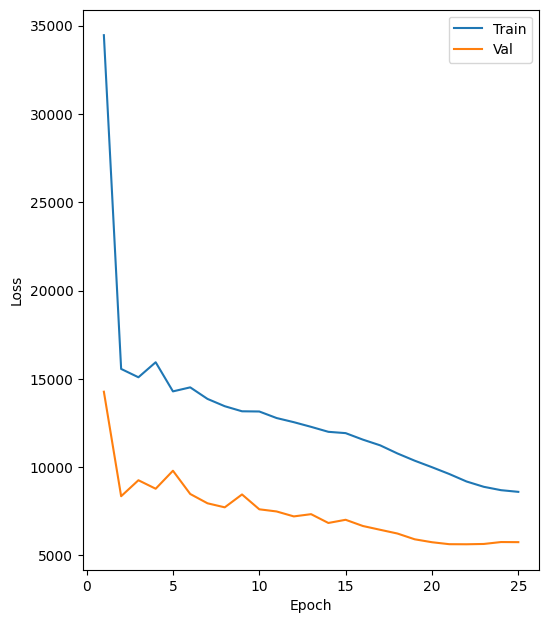

best loss 5630.476285691229 epoch 22
dropout1:  0 dropout2:  0 batch size:  8 shuffle validation:  False
Test set: Average loss: 101.8960
Test set: Average loss: 96.6286
Test set: Average loss: 87.0651
Test set: Average loss: 98.9200
Train Epoch : 5train_loss = 122.51692810021203 
Test set: Average loss: 92.3137
Test set: Average loss: 93.8711
Test set: Average loss: 92.9715
Test set: Average loss: 84.9608
Test set: Average loss: 87.4363
Train Epoch : 10train_loss = 115.50175808042867 
Test set: Average loss: 90.5952
Test set: Average loss: 82.7230
Test set: Average loss: 81.0241
Test set: Average loss: 82.3865
Test set: Average loss: 78.7054
Train Epoch : 15train_loss = 106.9895077370267 
Test set: Average loss: 80.8867
Test set: Average loss: 77.7295
Test set: Average loss: 78.2087
Test set: Average loss: 77.1878
Test set: Average loss: 76.9376
Train Epoch : 20train_loss = 97.38362064961255 
Test set: Average loss: 76.3402
Test set: Average loss: 76.2215
Test set: Average loss: 75.55

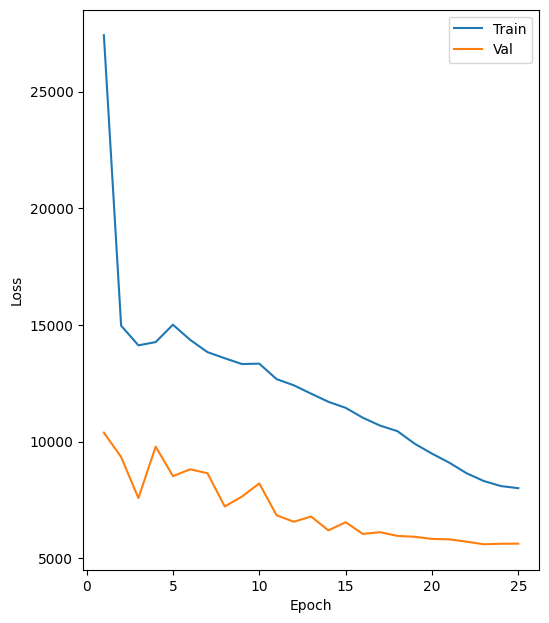

best loss 5614.660408903288 epoch 23
dropout1:  0 dropout2:  0.3 batch size:  8 shuffle validation:  True
Test set: Average loss: 96.3970
Test set: Average loss: 88.5507
Test set: Average loss: 90.7651
Test set: Average loss: 98.7269
Train Epoch : 5train_loss = 119.05062070281943 
Test set: Average loss: 87.4169
Test set: Average loss: 86.2601
Test set: Average loss: 89.8433
Test set: Average loss: 86.7157
Test set: Average loss: 85.7013
Train Epoch : 10train_loss = 116.92176432605243 
Test set: Average loss: 84.3773
Test set: Average loss: 82.2347
Test set: Average loss: 88.6335
Test set: Average loss: 83.3536


KeyboardInterrupt: ignored

In [15]:
# parameter for the training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Constant

optimizer_kwargs = dict(
    lr=5e-4,
    weight_decay=1e-3,
) # constant

# Variables
dropout1 = [0, 0.3, 0.5] # Dropout rates for the first layer
dropout2 = [0, 0.3, 0.5] # Dropout rates for the second layer
batch_size = [8]
shuffle_val = [True, False]
num_epochs = 25

# Combine hyperparameters
hyperparameter_combinations = list(itertools.product(dropout1, dropout2, batch_size, shuffle_val))

# Define the K-fold Cross Validation
# folds = 4
# kfold = KFold(n_splits=folds, shuffle=True)
#criterion = RMSELoss
criterion = F.mse_loss #criterion for the training


# initialize each variables
result_model = []
result_best_val_loss = []  # Initialize with positive infinity
result_best_epoch = []

best_dpt1 = -1
best_dpt2 = -1
best_batch_size_ = -1
best_shuffle = None

#iterate on each fold
for dpt1, dpt2, batch_size_, shuffle_val_ in hyperparameter_combinations :
  print('dropout1: ', dpt1, 'dropout2: ', dpt2, 'batch size: ', batch_size_, 'shuffle validation: ', shuffle_val_)
  model = Net2(dropout1 = dpt1, dropout2 = dpt2)
  model = model.to(device=device)

  ghi_train_shuffle = shuffle(ghi_train)
  train_loader = DataLoader(ghi_train_shuffle, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train)), batch_size=batch_size_, dec = batch_size_))
  if shuffle_val_:
    ghi_test_ = shuffle(ghi_test)
  else : ghi_test_ = ghi_test
  val_loader = DataLoader(ghi_test_, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_test)), batch_size=batch_size_, dec = batch_size_))


  #prepare the model
  model.apply(reset_weights)
  optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // batch_size_,)
  # ===== Train Model =====
  best_val_loss = float('inf')  # Initialize with positive infinity
  best_epoch = 0
  #train_loss_history = []
  train_loss_step = []
  #val_loss_history = []
  val_loss_step = []
  for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, optimizer,scheduler, criterion, train_loader, epoch, device)
    #train_loss_history.extend(train_loss)
    train_loss_step.append(np.mean(train_loss))

    val_loss = validate(model, device, val_loader, criterion)
    #val_loss_history.extend(val_loss)
    loss = np.mean(val_loss)
    val_loss_step.append(loss)

    # Save the model with the lowest validation loss
    if loss < best_val_loss:
      best_val_loss = loss
      best_epoch = epoch
      best_dpt1 = dpt1
      best_dpt2 = dpt2
      best_batch_size = batch_size_
      best_shuffle = shuffle_val_
      best_model_state = model.state_dict()

  print("best loss ",best_val_loss, "epoch ", best_epoch, 'dropout1 ', dpt1, 'dropout2 ', dpt2, 'batch_size ', batch_size_, 'shuffle validation ', shuffle_val_)
  result_model.append(best_model_state)
  result_best_val_loss.append(best_val_loss)
  result_best_epoch.append(best_epoch)

    # ===== Plot training curves =====
  t_val = np.arange(1, num_epochs + 1)

    # Increase the size of the plot
  plt.figure(figsize=(20, 16))

  plt.subplot(2, 3, 2)
  plt.plot(t_val, train_loss_step, label="Train")
  plt.plot(t_val, val_loss_step, label="Val")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  # define best parameters
  mean_loss = np.mean(result_best_val_loss)
  mean_epoch = math.ceil(np.mean(result_best_epoch))
  print("best loss",np.mean(result_best_val_loss), "epoch", mean_epoch)


# Train Net2 (with other parameters)


Epoch :  1 / 25
Train Epoch : 1train_loss = 168.69859091409396 
Epoch :  2 / 25
Train Epoch : 2train_loss = 122.11397815170984 
Epoch :  3 / 25
Train Epoch : 3train_loss = 119.25750133164532 
Epoch :  4 / 25
Train Epoch : 4train_loss = 118.53146352018662 
Epoch :  5 / 25
Train Epoch : 5train_loss = 117.78668818863427 
Epoch :  6 / 25
Train Epoch : 6train_loss = 116.61907080891058 
Epoch :  7 / 25
Train Epoch : 7train_loss = 117.01110418919882 
Epoch :  8 / 25
Train Epoch : 8train_loss = 115.01515512942484 
Epoch :  9 / 25
Train Epoch : 9train_loss = 113.89301838254386 
Epoch :  10 / 25
Train Epoch : 10train_loss = 113.62422523525284 
Epoch :  11 / 25
Train Epoch : 11train_loss = 111.99040266891386 
Epoch :  12 / 25
Train Epoch : 12train_loss = 111.41309316690759 
Epoch :  13 / 25
Train Epoch : 13train_loss = 111.83931825153677 
Epoch :  14 / 25
Train Epoch : 14train_loss = 109.98144740797736 
Epoch :  15 / 25
Train Epoch : 15train_loss = 108.72244956915814 
Epoch :  16 / 25
Train Epoch

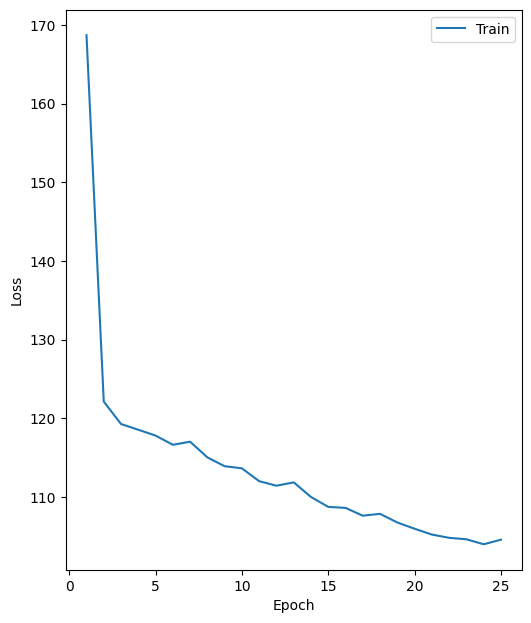

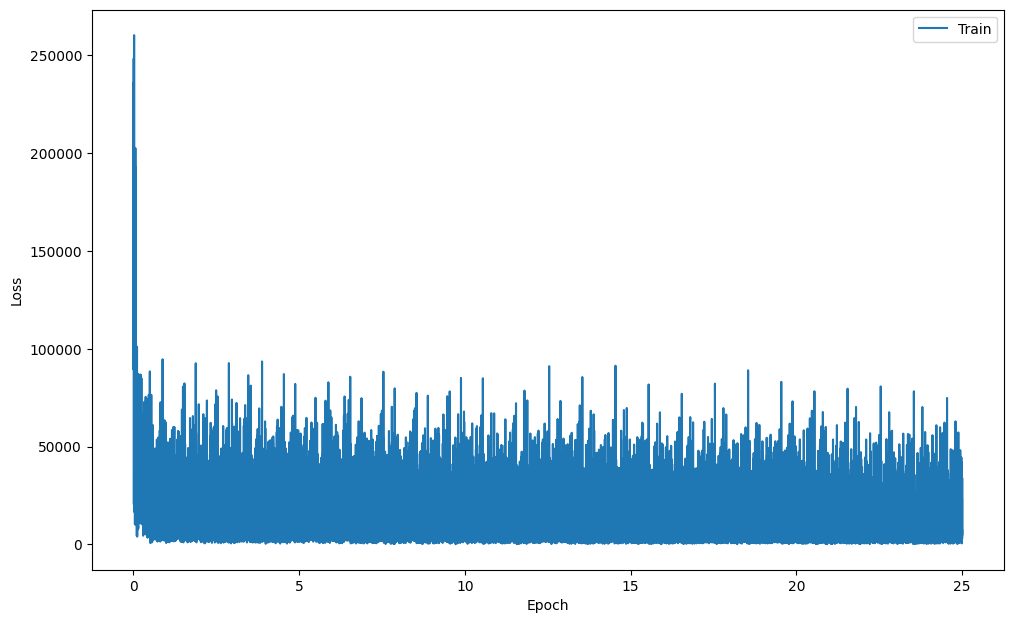

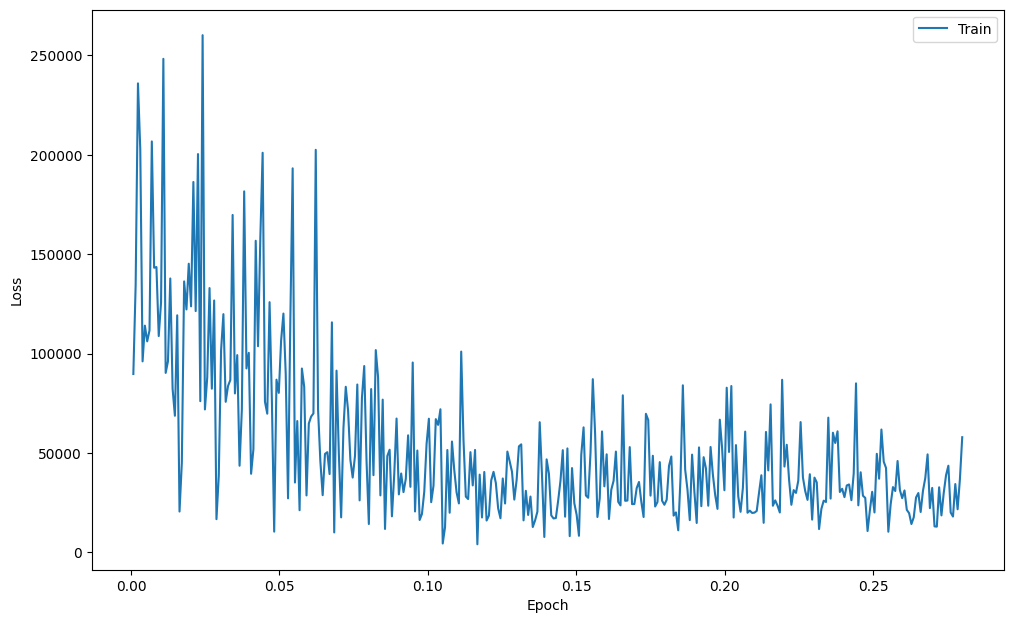

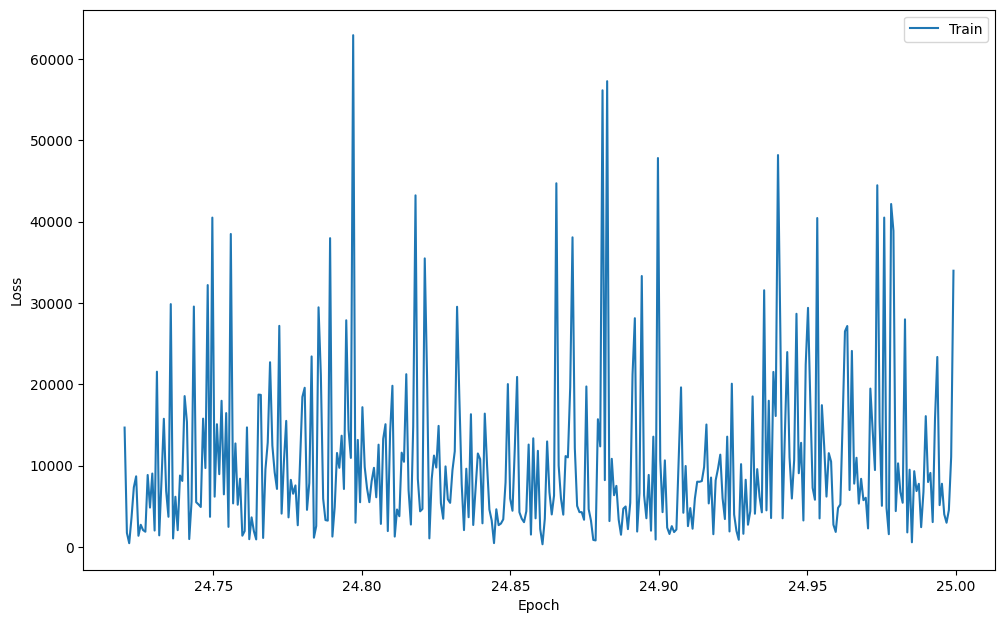

In [ ]:
# parameter for the training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_kwargs = dict( # how did you decice that ?
    lr=5e-4,
    weight_decay=1e-3,
)

model = Net2()
model = model.to(device=device)
model.apply(reset_weights)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
#parameter
#num_epochs = mean_epoch
num_epochs = 25
batch_size = 8
#define the loader
ghi_train_shuffle = shuffle(ghi_train)
train_loader = DataLoader(ghi_train_shuffle, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train_shuffle)), batch_size=batch_size, dec = 8))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // batch_size)

criterion = F.mse_loss #criterion for the training



# ===== Train Model =====
train_loss_history = []
train_loss_step = []
for epoch in range(1, num_epochs + 1):
  print("Epoch : ",epoch,"/",num_epochs)
  train_loss = train_epoch(model, optimizer,scheduler, criterion, train_loader, epoch, device)
  train_loss_history.extend(train_loss)
  train_loss_step.append(np.sqrt(np.mean(train_loss)))

# ===== Plot training curves =====
t_val = np.arange(1, num_epochs + 1)

# Increase the size of the plot
plt.figure(figsize=(20, 16))

plt.subplot(2, 3, 2)
plt.plot(t_val, train_loss_step, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Increase the size of the plot
plt.figure(figsize=(40, 16))

t_train = np.arange(1, len(train_loss_history) + 1)/len(train_loss_history)*num_epochs

plt.subplot(2, 3, 2)
plt.plot(t_train, train_loss_history, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()


# Increase the size of the plot
plt.figure(figsize=(40, 16))


plt.subplot(2, 3, 2)
plt.plot(t_train[0:360], train_loss_history[0:360], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Increase the size of the plot
plt.figure(figsize=(40, 16))

plt.subplot(2, 3, 2)
plt.plot(t_train[-361:-1], train_loss_history[-361:-1], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Test Net2

the test loss is  68.80745370239713


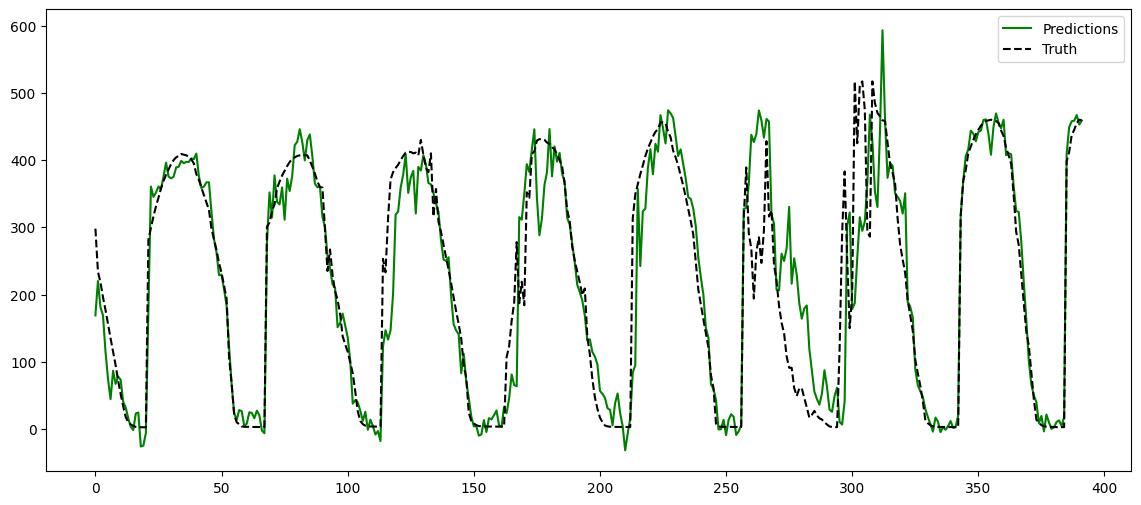

In [ ]:
test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_test)), batch_size=8, dec = 8))

pred = []
truth = []
test_loss = []
model.eval()
for data in test_loader:
  data = list(feature.to(device) for feature in data)
  target = data.pop()
  output = model(*data)

  pred.extend(output.tolist())
  truth.extend(target.tolist())
  test_loss.append(criterion(output, target).item())

Loss = np.sqrt(np.mean(test_loss))

print("the test loss is ",Loss)
#### a plot to visualize our predictions vs the true vlaues
plt.figure(figsize=(14,6))
plt.plot(pred, 'g', label = "Predictions")
plt.plot(truth, '--k',label = 'Truth')
plt.legend(loc = 'best')